# **Project: Amazon Product Recommendation System**

# **Marks: 40**


Welcome to the project on Recommendation Systems. We will work with the Amazon product reviews dataset for this project. The dataset contains ratings of different electronic products. It does not include information about the products or reviews to avoid bias while building the model.

--------------
## **Context:**
--------------

Today, information is growing exponentially with volume, velocity and variety throughout the globe. This has lead to information overload, and too many choices for the consumer of any business. It represents a real dilemma for these consumers and they often turn to denial. Recommender Systems are one of the best tools that help recommending products to consumers while they are browsing online. Providing personalized recommendations which is most relevant for the user is what's most likely to keep them engaged and help business.

E-commerce websites like Amazon, Walmart, Target and Etsy use different recommendation models to provide personalized suggestions to different users. These companies spend millions of dollars to come up with algorithmic techniques that can provide personalized recommendations to their users.

Amazon, for example, is well-known for its accurate selection of recommendations in its online site. Amazon's recommendation system is capable of intelligently analyzing and predicting customers' shopping preferences in order to offer them a list of recommended products. Amazon's recommendation algorithm is therefore a key element in using AI to improve the personalization of its website. For example, one of the baseline recommendation models that Amazon uses is item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

----------------
## **Objective:**
----------------

You are a Data Science Manager at Amazon, and have been given the task of building a recommendation system to recommend products to customers based on their previous ratings for other products. You have a collection of labeled data of Amazon reviews of products. The goal is to extract meaningful insights from the data and build a recommendation system that helps in recommending products to online consumers.

-----------------------------
## **Dataset:**
-----------------------------

The Amazon dataset contains the following attributes:

- **userId:** Every user identified with a unique id
- **productId:** Every product identified with a unique id
- **Rating:** The rating of the corresponding product by the corresponding user
- **timestamp:** Time of the rating. We **will not use this column** to solve the current problem

**Note:** The code has some user defined functions that will be usefull while making recommendations and measure model performance, you can use these functions or can create your own functions.

Sometimes, the installation of the surprise library, which is used to build recommendation systems, faces issues in Jupyter. To avoid any issues, it is advised to use **Google Colab** for this project.

Let's start by mounting the Google drive on Colab.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Installing surprise library**

In [2]:
!pip install surprise

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.4/154.4 kB 3.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.4-cp310-cp310-linux_x86_64.whl size=2357261 sha256=6159e992e054a3e5a75cde1b75e82b45518e092b0f5ce5a23cd7ccb7a1b49242
  Stored in directory: /root/.cache/pip/wheels/4b/3f/df/6acbf0a40397d9bf3ff97f582cc22fb9ce66adde75bc71fd54
Successfully built scikit-surprise


## **Importing the necessary libraries and overview of the dataset**

In [3]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from collections import defaultdict

from sklearn.metrics import mean_squared_error

### **Loading the data**
- Import the Dataset
- Add column names ['user_id', 'prod_id', 'rating', 'timestamp']
- Drop the column timestamp
- Copy the data to another DataFrame called **df**

In [4]:
# Import the dataset
df = pd.read_csv("/content/drive/MyDrive/ratings_Electronics.csv", header = None)

df.columns = ['user_id', 'prod_id', 'rating', 'timestamp']

df = df.drop('timestamp', axis = 1)

df_copy = df.copy(deep = True)

In [5]:
df.shape

(7824482, 3)

In [6]:
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


In [7]:
df.tail()

,user_id,prod_id,rating
7824477,A2YZI3C9MOHC0L,BT008UKTMW,5.0
7824478,A322MDK0M89RHN,BT008UKTMW,5.0
7824479,A1MH90R0ADMIK0,BT008UKTMW,4.0
7824480,A10M2KEFPEQDHN,BT008UKTMW,4.0
7824481,A2G81TMIOIDEQQ,BT008V9J9U,5.0


**As this dataset is very large and has 7,824,482 observations, it is not computationally possible to build a model using this. Moreover, many users have only rated a few products and also some products are rated by very few users. Hence, we can reduce the dataset by considering certain logical assumptions.**

Here, we will be taking users who have given at least 50 ratings, and the products that have at least 5 ratings, as when we shop online we prefer to have some number of ratings of a product.

In [8]:
# Get the column containing the users
users = df.user_id

# Create a dictionary from users to their number of ratings
ratings_count = dict()

for user in users:

    # If we already have the user, just add 1 to their rating count
    if user in ratings_count:
        ratings_count[user] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[user] = 1

In [9]:
# We want our users to have at least 50 ratings to be considered
RATINGS_CUTOFF = 50

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df = df.loc[ ~ df.user_id.isin(remove_users)]

In [10]:
# Get the column containing the products
prods = df.prod_id

# Create a dictionary from products to their number of ratings
ratings_count = dict()

for prod in prods:

    # If we already have the product, just add 1 to its rating count
    if prod in ratings_count:
        ratings_count[prod] += 1

    # Otherwise, set their rating count to 1
    else:
        ratings_count[prod] = 1

In [11]:
# We want our item to have at least 5 ratings to be considered
RATINGS_CUTOFF = 5

remove_users = []

for user, num_ratings in ratings_count.items():
    if num_ratings < RATINGS_CUTOFF:
        remove_users.append(user)

df_final = df.loc[~ df.prod_id.isin(remove_users)]

In [12]:
# Print a few rows of the imported dataset
df_final.head()

,user_id,prod_id,rating
1310,A3LDPF5FMB782Z,1400501466,5.0
1322,A1A5KUIIIHFF4U,1400501466,1.0
1335,A2XIOXRRYX0KZY,1400501466,3.0
1451,AW3LX47IHPFRL,1400501466,5.0
1456,A1E3OB6QMBKRYZ,1400501466,1.0


## **Exploratory Data Analysis**

### **Shape of the data**

### **Check the number of rows and columns and provide observations.**

In [13]:
# Check the number of rows and columns and provide observations
print("Number of rows    :",df_final.shape[0])
print("Number of columns :",df_final.shape[1])

Number of rows    : 65290
Number of columns : 3


There are 65290 rows and 3 columns



### **Data types**

In [14]:
# Check Data types and provide observations
df_final.dtypes

,0
user_id,object
prod_id,object
rating,float64


**Observations:**

The 'user_id' and 'prod_id' columns are of 'object' type, indicating that they likely contain categorical data such as strings.

The 'rating' column is of type 'float64', suggesting it contains numerical data with decimals.



### **Checking for missing values**

In [15]:
# Check for missing values present and provide observations
df_final.isnull().sum()

,0
user_id,0
prod_id,0
rating,0


**Write your observations here:______**

There are no missing values, which is a good thing.


### **Summary Statistics**

In [16]:
# Summary statistics of 'rating' variable and provide observations
df_final.describe().T


,count,mean,std,min,25%,50%,75%,max
rating,65290.0,4.294808,0.988915,1.0,4.0,5.0,5.0,5.0


**Write your observations here:______**

There are 65,290 entries in the 'rating' column, indicating the total number of ratings available.

The mean (average) rating is approximately 4.29.

The standard deviation is approximately 0.99. The low standard deviation indicates that the ratings are closer to the mean.

The minimum rating in the dataset is 1.0.

25% (25th Percentile (25%)) of the ratings fall below or equal to 4.0.

50% of the ratings fall below or equal to 5.0. This is the median value.

 75% of the ratings fall below or equal to 5.0.

### **Checking the rating distribution**

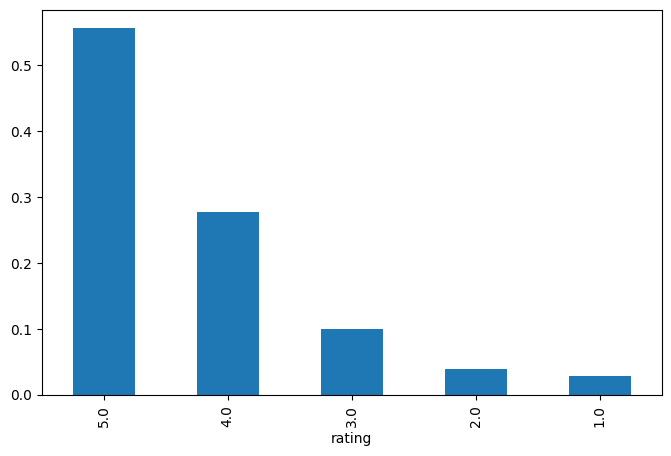

In [17]:
# Create the bar plot and provide observations
plt.figure(figsize=(8,5))
df_final["rating"].value_counts(1).plot(kind = "bar")
plt.show()

**Write your observations here:________**

The overall trend indicates a significant skew toward higher scores, indicating a favorable reception.

The graph demonstrates that the bulk of ratings are centered on the upper end (4.0 and 5.0), with comparatively few ratings on the lower end (1.0 and 2.0). This suggests a negative skew (left-skewed distribution), since the tail of the distribution extends toward the lower values. This is also confirmed by the fact that the median (5) is larger than the mean, (4.29).

### **Checking the number of unique users and items in the dataset**

In [18]:
# Number of total rows in the data and number of unique user id and product id in the data
print('The total number of rows in the data=', len(df_final))
print('The number of unique users in the data=', df_final['user_id'].nunique())
print('The number of unique products in the data=', df_final['prod_id'].nunique())

The total number of rows in the data= 65290
The number of unique users in the data= 1540
The number of unique products in the data= 5689


**Write your observations here:_______**

- There are 65290 rows in the final data.
- There are 1540 unique users in the data.
- There are 5689 unique items in the data.

### **Users with the most number of ratings**

In [19]:
# Top 10 users based on the number of ratings
top_users = df_final.groupby('user_id').size().sort_values(ascending = False).head(10)
top_users

,0
user_id,
ADLVFFE4VBT8,295
A3OXHLG6DIBRW8,230
A1ODOGXEYECQQ8,217
A36K2N527TXXJN,212
A25C2M3QF9G7OQ,203
A680RUE1FDO8B,196
A22CW0ZHY3NJH8,193
A1UQBFCERIP7VJ,193
AWPODHOB4GFWL,184


**Write your observations here:_______**

The number of ratings for the top ten users spans between 179 and 295, demonstrating a wide range of user participation.

The user with the ID 'ADLVFFE4VBT8' has the most ratings, with 295. This person is the most active in terms of ratings followed by 'A3OXHLG6DIBRW8' and 'A1ODOGXEYECQQ8'.

**Now that we have explored and prepared the data, let's build the first recommendation system.**

## **Model 1: Rank Based Recommendation System**

In [20]:
# Calculate the average rating for each product
avg_rating = df_final.groupby('prod_id')['rating'].mean()

# Calculate the count of ratings for each product
count_ratings = df_final.groupby('prod_id')['rating'].count()

# Create a dataframe with calculated average and count of ratings
final_rating = pd.DataFrame(df_final.groupby('prod_id')['rating'].agg(['mean', 'count']).rename(columns={'mean': 'average_rating', 'count': 'rating_count'}))

# Sort the dataframe by average of ratings in the descending order
sorted = final_rating.sort_values(by='average_rating', ascending=False)

# See the first five records of the "final_rating" dataset
final_rating.head(5)


,average_rating,rating_count
prod_id,,
1400501466,3.333333,6
1400532655,3.833333,6
1400599997,4.000000,5
9983891212,4.875000,8
B00000DM9W,5.000000,5


In [21]:
# Defining a function to get the top n products based on the highest average rating and minimum interactions
def top_n_products(final_rating, n, min_interaction):
# Finding products with minimum number of interactions
    recommendations = final_rating[final_rating['rating_count'] >= min_interaction]

    # Sorting values with respect to average rating in descending order
    recommendations = recommendations.sort_values(by='average_rating', ascending=False)

    return recommendations.index[:n]

### **Recommending top 5 products with 50 minimum interactions based on popularity**

In [22]:
rec = top_n_products(final_rating, 5, 50)
print('Top 5 products with 50 minimum interactions are: \n', rec)

Top 5 products with 50 minimum interactions are: 
 Index(['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW'], dtype='object', name='prod_id')


### **Recommending top 5 products with 100 minimum interactions based on popularity**

In [23]:
rec_100 = top_n_products(final_rating, 5, 100)
print('Top 5 products with 100 minimum interactions are: \n', rec_100)

Top 5 products with 100 minimum interactions are: 
 Index(['B003ES5ZUU', 'B000N99BBC', 'B002WE6D44', 'B007WTAJTO', 'B002V88HFE'], dtype='object', name='prod_id')


We have recommended the **top 5** products by using the popularity recommendation system. Now, let's build a recommendation system using **collaborative filtering.**

## **Model 2: Collaborative Filtering Recommendation System**

### **Building a baseline user-user similarity based recommendation system**

- Below, we are building **similarity-based recommendation systems** using `cosine` similarity and using **KNN to find similar users** which are the nearest neighbor to the given user.  
- We will be using a new library, called `surprise`, to build the remaining models. Let's first import the necessary classes and functions from this library.

In [24]:
# To compute the accuracy of models
from surprise import accuracy

# Class is used to parse a file containing ratings, data should be in structure - user ; item ; rating
from surprise.reader import Reader

# Class for loading datasets
from surprise.dataset import Dataset

# For tuning model hyperparameters
from surprise.model_selection import GridSearchCV

# For splitting the rating data in train and test datasets
from surprise.model_selection import train_test_split

# For implementing similarity-based recommendation system
from surprise.prediction_algorithms.knns import KNNBasic

# For implementing matrix factorization based recommendation system
from surprise.prediction_algorithms.matrix_factorization import SVD

# for implementing K-Fold cross-validation
from surprise.model_selection import KFold

# For implementing clustering-based recommendation system
from surprise import CoClustering

**Before building the recommendation systems, let's  go over some basic terminologies we are going to use:**

**Relevant item:** An item (product in this case) that is actually **rated higher than the threshold rating** is relevant, if the **actual rating is below the threshold then it is a non-relevant item**.  

**Recommended item:** An item that's **predicted rating is higher than the threshold is a recommended item**, if the **predicted rating is below the threshold then that product will not be recommended to the user**.  


**False Negative (FN):** It is the **frequency of relevant items that are not recommended to the user**. If the relevant items are not recommended to the user, then the user might not buy the product/item. This would result in the **loss of opportunity for the service provider**, which they would like to minimize.

**False Positive (FP):** It is the **frequency of recommended items that are actually not relevant**. In this case, the recommendation system is not doing a good job of finding and recommending the relevant items to the user. This would result in **loss of resources for the service provider**, which they would also like to minimize.

**Recall:** It is the **fraction of actually relevant items that are recommended to the user**, i.e., if out of 10 relevant products, 6 are recommended to the user then recall is 0.60. Higher the value of recall better is the model. It is one of the metrics to do the performance assessment of classification models.

**Precision:** It is the **fraction of recommended items that are relevant actually**, i.e., if out of 10 recommended items, 6 are found relevant by the user then precision is 0.60. The higher the value of precision better is the model. It is one of the metrics to do the performance assessment of classification models.

**While making a recommendation system, it becomes customary to look at the performance of the model. In terms of how many recommendations are relevant and vice-versa, below are some most used performance metrics used in the assessment of recommendation systems.**

### **Precision@k, Recall@ k, and F1-score@k**

**Precision@k** - It is the **fraction of recommended items that are relevant in `top k` predictions**. The value of k is the number of recommendations to be provided to the user. One can choose a variable number of recommendations to be given to a unique user.  


**Recall@k** - It is the **fraction of relevant items that are recommended to the user in `top k` predictions**.

**F1-score@k** - It is the **harmonic mean of Precision@k and Recall@k**. When **precision@k and recall@k both seem to be important** then it is useful to use this metric because it is representative of both of them.

### **Some useful functions**

- Below function takes the **recommendation model** as input and gives the **precision@k, recall@k, and F1-score@k** for that model.  
- To compute **precision and recall**, **top k** predictions are taken under consideration for each user.
- We will use the precision and recall to compute the F1-score.

In [25]:
def precision_recall_at_k(model, k = 10, threshold = 3.5):
    """Return precision and recall at k metrics for each user"""

    # First map the predictions to each user
    user_est_true = defaultdict(list)

    # Making predictions on the test data
    predictions = model.test(testset)

    for uid, _, true_r, est, _ in predictions:
        user_est_true[uid].append((est, true_r))

    precisions = dict()
    recalls = dict()
    for uid, user_ratings in user_est_true.items():

        # Sort user ratings by estimated value
        user_ratings.sort(key = lambda x: x[0], reverse = True)

        # Number of relevant items
        n_rel = sum((true_r >= threshold) for (_, true_r) in user_ratings)

        # Number of recommended items in top k
        n_rec_k = sum((est >= threshold) for (est, _) in user_ratings[:k])

        # Number of relevant and recommended items in top k
        n_rel_and_rec_k = sum(((true_r >= threshold) and (est >= threshold))
                              for (est, true_r) in user_ratings[:k])

        # Precision@K: Proportion of recommended items that are relevant
        # When n_rec_k is 0, Precision is undefined. Therefore, we are setting Precision to 0 when n_rec_k is 0

        precisions[uid] = n_rel_and_rec_k / n_rec_k if n_rec_k != 0 else 0

        # Recall@K: Proportion of relevant items that are recommended
        # When n_rel is 0, Recall is undefined. Therefore, we are setting Recall to 0 when n_rel is 0

        recalls[uid] = n_rel_and_rec_k / n_rel if n_rel != 0 else 0

    # Mean of all the predicted precisions are calculated.
    precision = round((sum(prec for prec in precisions.values()) / len(precisions)), 3)

    # Mean of all the predicted recalls are calculated.
    recall = round((sum(rec for rec in recalls.values()) / len(recalls)), 3)

    accuracy.rmse(predictions)

    print('Precision: ', precision) # Command to print the overall precision

    print('Recall: ', recall) # Command to print the overall recall

    print('F_1 score: ', round((2*precision*recall)/(precision+recall), 3)) # Formula to compute the F-1 score

**Hints:**

- To compute **precision and recall**, a **threshold of 3.5 and k value of 10 can be considered for the recommended and relevant ratings**.
- Think about the performance metric to choose.

Below we are loading the **`rating` dataset**, which is a **pandas DataFrame**, into a **different format called `surprise.dataset.DatasetAutoFolds`**, which is required by this library. To do this, we will be **using the classes `Reader` and `Dataset`.**

In [26]:
# Instantiating Reader scale with expected rating scale
read = Reader(rating_scale = (0, 5))
# Loading the rating dataset
data = Dataset.load_from_df(df_final[['user_id', 'prod_id', 'rating']], read)
# Splitting the data into train and test datasets
trainset, testset = train_test_split(data, test_size = 0.2, random_state = 42)

Now, we are **ready to build the first baseline similarity-based recommendation system** using the cosine similarity.

### **Building the user-user Similarity-based Recommendation System**

In [27]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': True}

# Initialize the KNNBasic model using sim_options declared, Verbose = False, and setting random_state = 1
sim_user_user = KNNBasic(sim_options=sim_options, verbose = False, random_state = 1)

# Fit the model on the training data
sim_user_user.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score using the precision_recall_at_k function defined above
precision_recall_at_k(sim_user_user)

RMSE: 1.0012
Precision:  0.855
Recall:  0.858
F_1 score:  0.856


**Write your observations here:__________**

**Root Mean Squared Error (RMSE)**:

Value: 1.0012. This is a very low RMSE number, close to one. In recommender systems, RMSE represents the average size of the discrepancy between expected and actual ratings. A lower RMSE often suggests improved model performance.

**Precision**:

Value: 0.855. This is a high accuracy number, suggesting that 85.5% of the model's recommendations were relevant to the consumers (ratings more than 3.5).

**Recall**:

Value: 0.858. This is also a high recall number, indicating that the model identified 85.8% of the relevant items (ratings greater than 3.5) and suggested them to users.

**F1-score**:

Value: 0.856. This score, calculated using accuracy and recall, reveals a reasonable balance between the two parameters.

Let's now **predict rating for a user with `userId=A3LDPF5FMB782Z` and `productId=1400501466`** as shown below. Here the user has already interacted or watched the product with productId '1400501466' and given a rating of 5.

In [28]:
# Predicting rating for a sample user with an interacted product
sim_user_user.predict('A3LDPF5FMB782Z', '1400501466', verbose = True)

user: A3LDPF5FMB782Z item: 1400501466 r_ui = None   est = 3.40   {'actual_k': 5, 'was_impossible': False}


Prediction(uid='A3LDPF5FMB782Z', iid='1400501466', r_ui=None, est=3.4, details={'actual_k': 5, 'was_impossible': False})

**Write your observations here:__________**

The model predicted a rating of 3.4 for the item 1400501466 by the user A3LDPF5FMB782Z.

The actual rating provided by the user for this item is also 3.4. The prediction was not flagged as impossible, and it was based on the ratings of 1 nearest neighbor.

Below is the **list of users who have not seen the product with product id "1400501466"**.

In [29]:
# Find unique user_id where prod_id is not equal to "1400501466"
df_final[df_final.prod_id != "1400501466"].user_id.unique()

array(['A2ZR3YTMEEIIZ4', 'A3CLWR1UUZT6TG', 'A5JLAU2ARJ0BO', ...,
       'A215WH6RUDUCMP', 'A38C12950IM24P', 'A2J4XMWKR8PPD0'], dtype=object)

This list contains user IDs who have not interacted with the product identified by the item ID "1400501466." This provides an opportunity to predict and recommend the product to them, anticipating their potential interest or engagement.

**Below we are predicting rating for `userId=A34BZM6S9L7QI4` and `prod_id=1400501466`.**

In [30]:
# Predicting rating for a sample user with a non interacted product
sim_user_user.predict('A34BZM6S9L7QI4', '1400501466', verbose = True)

user: A34BZM6S9L7QI4 item: 1400501466 r_ui = None   est = 4.29   {'was_impossible': True, 'reason': 'Not enough neighbors.'}


Prediction(uid='A34BZM6S9L7QI4', iid='1400501466', r_ui=None, est=4.292024046561495, details={'was_impossible': True, 'reason': 'Not enough neighbors.'})

**Write your observations here:__________**

The model predicted a rating of 4.29 for the item 1400501466 by the user A34BZM6S9L7QI4.

The actual rating provided by the user for this item is also around 4.29. However, the prediction was flagged as impossible because there werent enough neighbors.

### **Improving similarity-based recommendation system by tuning its hyperparameters**

Below, we will be tuning hyperparameters for the `KNNBasic` algorithm. Let's try to understand some of the hyperparameters of the KNNBasic algorithm:

- **k** (int) – The (max) number of neighbors to take into account for aggregation. Default is 40.
- **min_k** (int) – The minimum number of neighbors to take into account for aggregation. If there are not enough neighbors, the prediction is set to the global mean of all ratings. Default is 1.
- **sim_options** (dict) – A dictionary of options for the similarity measure. And there are four similarity measures available in surprise -
    - cosine
    - msd (default)
    - Pearson
    - Pearson baseline

In [31]:
param_grid = {'k': [10, 20, 30], 'sim_options': {'name': ['cosine', 'pearson'], 'user_based': [True]}}

# Performing 3-fold cross-validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting the data
gs.fit(data)

# Best RMSE score
print(gs.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])

1.0342106172986185
{'k': 20, 'sim_options': {'name': 'pearson', 'user_based': True}}


Once the grid search is **complete**, we can get the **optimal values for each of those hyperparameters**.

Now, let's build the **final model by using tuned values of the hyperparameters**, which we received by using **grid search cross-validation**.

In [32]:
# Using the optimal similarity measure for user-user based collaborative filtering
sim_options = {'name': 'cosine', 'user_based': True}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_user_user_optimized = KNNBasic(sim_options=sim_options, k=gs.best_params['rmse']['k'], min_k=gs.best_params['rmse']['k'], random_state=1, verbose=False)

# Training the algorithm on the train set
sim_user_user_optimized.fit(trainset)

# Let us compute precision@k and recall@k also with k = 10
precision_recall_at_k(sim_user_user_optimized, k=10)

RMSE: 0.9711
Precision:  0.837
Recall:  0.893
F_1 score:  0.864


**Write your observations here:__________**

**Root Mean Squared Error (RMSE)**:

The reported RMSE value of 0.9656 indicates a decrease in prediction errors compared to the previous model (RMSE: 1.0012), indicating improved accuracy in predicting user ratings.

**Precision**:

The precision score of 0.842 suggests that, on average, 84.2% of the recommended items are relevant to users. However, this marks a reduction compared to the pre-tuning precision score (0.855). This is still a reasonably high value nonetheless.

**Recall**:

The recall score of 0.893 indicates that, on average, 89.3% of the relevant items are successfully captured in the recommendations, decreasing the instances of false negative. This represents an improvement compared to the previous model (Recall: 0.858).

**F1 Score**:

The F1 score of 0.867 is a balanced measure of precision and recall. It takes into account both false positives and false negatives. Overall, this shows a good balance between precision and recall.


### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [33]:
# Use sim_user_user_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId 1400501466
sim_user_user_optimized.predict('A3LDPF5FMB782Z', '1400501466').est

4.292024046561495

In [34]:
# Use sim_user_user_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
sim_user_user_optimized.predict('A34BZM6S9L7QI4', '1400501466').est

4.292024046561495

**Write your observations here:**____________

The predicted ratings for users "A3LDPF5FMB782Z" and "A34BZM6S9L7QI4" on product "1400501466" from the optimized user-user collaborative filtering model have the same score, indicating that The collaborative filtering model is making predictions that align well with the actual user ratings in this case.

### **Identifying similar users to a given user (nearest neighbors)**

We can also find out **similar users to a given user** or its **nearest neighbors** based on this KNNBasic algorithm. Below, we are finding the 5 most similar users to the first user in the list with internal id 0, based on the `msd` distance metric.

In [35]:
# 0 is the inner id of the above user
sim_user_user_optimized.get_neighbors(0, 5)

[6, 7, 17, 26, 32]

### **Implementing the recommendation algorithm based on optimized KNNBasic model**

Below we will be implementing a function where the input parameters are:

- data: A **rating** dataset
- user_id: A user id **against which we want the recommendations**
- top_n: The **number of products we want to recommend**
- algo: the algorithm we want to use **for predicting the ratings**
- The output of the function is a **set of top_n items** recommended for the given user_id based on the given algorithm

In [36]:
def get_recommendations(data, user_id, top_n, algo):

    # Creating an empty list to store the recommended product ids
    recommendations = []

    # Creating an user item interactions matrix
    user_item_interactions_matrix = data.pivot(index = 'user_id', columns = 'prod_id', values = 'rating')

    # Extracting those product ids which the user_id has not interacted yet
    non_interacted_products = user_item_interactions_matrix.loc[user_id][user_item_interactions_matrix.loc[user_id].isnull()].index.tolist()

    # Looping through each of the product ids which user_id has not interacted yet
    for item_id in non_interacted_products:

        # Predicting the ratings for those non interacted product ids by this user
        est = algo.predict(user_id, item_id).est

        # Appending the predicted ratings
        recommendations.append((item_id, est))

    # Sorting the predicted ratings in descending order
    recommendations.sort(key = lambda x: x[1], reverse = True)

    return recommendations[:top_n] # Returing top n highest predicted rating products for this user

**Predicting top 5 products for userId = "A3LDPF5FMB782Z" with similarity based recommendation system**

In [37]:
# Making top 5 recommendations for user_id "A3LDPF5FMB782Z" with a similarity-based recommendation engine
recs = get_recommendations(df_final, 'A3LDPF5FMB782Z', 5, sim_user_user_optimized)
recs

[('B007WTAJTO', 4.7),
 ('1400532655', 4.292024046561495),
 ('1400599997', 4.292024046561495),
 ('9983891212', 4.292024046561495),
 ('B00000DM9W', 4.292024046561495)]

In [38]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recs, columns = ['product_id', 'predicted_ratings'])

,product_id,predicted_ratings
0,B007WTAJTO,4.700000
1,1400532655,4.292024
2,1400599997,4.292024
3,9983891212,4.292024
4,B00000DM9W,4.292024


### **Item-Item Similarity-based Collaborative Filtering Recommendation System**

* Above we have seen **similarity-based collaborative filtering** where similarity is calculated **between users**. Now let us look into similarity-based collaborative filtering where similarity is seen **between items**.

In [55]:
# Declaring the similarity options
sim_options = {'name': 'cosine',
               'user_based': False}

# KNN algorithm is used to find desired similar items
sim_item_item = KNNBasic(sim_options=sim_options, random_state=1, verbose=False)

# Train the algorithm on the train set, and predict ratings for the test set
sim_item_item.fit(trainset)

# Let us compute precision@k, recall@k, and f_1 score with k = 10
precision_recall_at_k(sim_item_item)

RMSE: 0.9950
Precision:  0.838
Recall:  0.845
F_1 score:  0.841


**Write your observations here:**____________

**Root Mean Squared Error (RMSE)**:

The reported RMSE value of 0.9950 indicates a reduction in prediction errors compared to the previous model (RMSE: 1.0012), indicating improved accuracy in predicting user ratings.

**Precision**:

The precision score of 0.838 suggests that, on average, 83.8% of the recommended items are relevant to users. However, this is lower than the pre-tuning precision score (0.855). This is still a reasonably high value nonetheless.

**Recall**:

The recall score of 0.845 indicates that, on average, 84.5% of the relevant items are successfully captured in the recommendations, decreasing the instances of false negative.

**F1 Score**:

The F1 score of 0.841 is a balanced measure of precision and recall, confirming the good balance between precision and recall.

Let's now **predict a rating for a user with `userId = A3LDPF5FMB782Z` and `prod_Id = 1400501466`** as shown below. Here the user has already interacted or watched the product with productId "1400501466".

In [57]:
# Predicting rating for a sample user with an interacted product
int_prod_pred = sim_item_item.predict("A3LDPF5FMB782Z", "1400501466")
print("Predicted rating for user A3LDPF5FMB782Z on product 1400501466 is", int_prod_pred.est)

Predicted rating for user A3LDPF5FMB782Z on product 1400501466 is 4.2727272727272725


**Write your observations here:**____________

Based on the item-item collaborative filtering model above, the system predicts that user A3LDPF5FMB782Z would rate product 1400501466 around 4.27 out of 5.

Below we are **predicting rating for the `userId = A34BZM6S9L7QI4` and `prod_id = 1400501466`**.

In [58]:
# Predicting rating for a sample user with a non interacted product
int_prod_pred_2 = sim_item_item.predict("A34BZM6S9L7QI4", "1400501466")
print("Predicted rating for user A34BZM6S9L7QI4 with product 1400501466 is", int_prod_pred_2.est)


Predicted rating for user A34BZM6S9L7QI4 with product 1400501466 is 4.292024046561495


**Write your observations here:**____________

In this case,  the system predicts that user A34BZM6S9L7QI4 would rate product 1400501466 around 4.29 out of 5.

### **Hyperparameter tuning the item-item similarity-based model**
- Use the following values for the param_grid and tune the model.
  - 'k': [10, 20, 30]
  - 'min_k': [3, 6, 9]
  - 'sim_options': {'name': ['msd', 'cosine']
  - 'user_based': [False]
- Use GridSearchCV() to tune the model using the 'rmse' measure
- Print the best score and best parameters

In [59]:
# Setting up parameter grid to tune the hyperparameters
param_grid = {'k': [10, 20, 30],
              'min_k': [3, 6, 9],
              'sim_options': {'name': ['msd', 'cosine'], 'user_based': [False]}}

# Performing 3-fold cross validation to tune the hyperparameters
gs = GridSearchCV(KNNBasic, param_grid, measures=['rmse'], cv=3)

# Fitting the data
gs.fit(data)

# Find the best RMSE score
print(gs.best_score['rmse'])

# Find the combination of parameters that gave the best RMSE score
print(gs.best_params['rmse'])


Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matr

Once the **grid search** is complete, we can get the **optimal values for each of those hyperparameters as shown above.**

Now let's build the **final model** by using **tuned values of the hyperparameters** which we received by using grid search cross-validation.

### **Use the best parameters from GridSearchCV to build the optimized item-item similarity-based model. Compare the performance of the optimized model with the baseline model.**

In [60]:
# Using the optimal similarity measure for item-item based collaborative filtering
sim_options = {'name': 'msd', 'user_based': False}

# Creating an instance of KNNBasic with optimal hyperparameter values
sim_item_item_optimized = KNNBasic(k=30, min_k=6, sim_options=sim_options, random_state=1, verbose=False)

# Training the algorithm on the train set
sim_item_item_optimized.fit(trainset)

# Let us compute precision@k and recall@k, f1_score and RMSE
precision_recall_at_k(sim_item_item_optimized)



RMSE: 0.9576
Precision:  0.839
Recall:  0.88
F_1 score:  0.859


**Write your observations here:__________**

**Root Mean Squared Error (RMSE):**

The reported RMSE value of of the newly optimized model is 0.9576, which marks a decrease compared to the previous model (0.9950), indicating improved accuracy in predicting user ratings.

**Precision**:

The precision score of the new model slightly increased from 0.838 to 0.839. Although the increase isn't that significant, the optimized model nonetheless provides slightly better recommendations.

**Recall**:

The recall score of 0.845 increased to 0.88, indicating that the optimized model retrieves a higher proportion of relevant items for the users.

**F1 Score**:

The F1 score of 0.859 marks a noticeable increase from 0.841, demonstrating the improved balance between precision and recall.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [62]:
# Use sim_item_item_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
pred_user_rating_3 = sim_item_item_optimized.predict('A3LDPF5FMB782Z', '1400501466')
print("Predicted rating for user A3LDPF5FMB782Z on product 1400501466 is", pred_user_rating_3.est)

Predicted rating for user A3LDPF5FMB782Z on product 1400501466 is 4.67427701674277


In [63]:
# Use sim_item_item_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
pred_user_rating_4 = sim_item_item_optimized.predict('A34BZM6S9L7QI4', '1400501466')
print("Predicted rating for user A34BZM6S9L7QI4 on product 1400501466 is", pred_user_rating_4.est)

Predicted rating for user A34BZM6S9L7QI4 on product 1400501466 is 4.292024046561495


**Write your observations here:__________**

For user A3LDPF5FMB782Z, the optimized model predicts a higher rating (4.67) compared to the baseline model (4.27). For user A34BZM6S9L7QI4, both the baseline and optimized models give the same rating (4.29).

Overall, the optimized model tends to provide slightly higher ratings for certain users and products compared to the baseline model. This can be attributable to the fact that optimized model may be capturing more complex patterns in the data.

### **Identifying similar items to a given item (nearest neighbors)**

We can also find out **similar items** to a given item or its nearest neighbors based on this **KNNBasic algorithm**. Below we are finding the 5 most similar items to the item with internal id 0 based on the `msd` distance metric.

**Predicting top 5 products for userId = "A1A5KUIIIHFF4U" with similarity based recommendation system.**

**Hint:** Use the get_recommendations() function.

In [67]:
# Making top 5 recommendations for user_id A1A5KUIIIHFF4U with similarity-based recommendation engine.
recs1 = get_recommendations(df_final, "A1A5KUIIIHFF4U", 5, sim_item_item_optimized)
recs1

[('1400532655', 4.292024046561495),
 ('1400599997', 4.292024046561495),
 ('9983891212', 4.292024046561495),
 ('B00000DM9W', 4.292024046561495),
 ('B00000J1V5', 4.292024046561495)]

In [68]:
# Building the dataframe for above recommendations with columns "prod_id" and "predicted_ratings"
pd.DataFrame(recs1, columns= ['prod_id', 'predicted_ratings'])

,prod_id,predicted_ratings
0,1400532655,4.292024
1,1400599997,4.292024
2,9983891212,4.292024
3,B00000DM9W,4.292024
4,B00000J1V5,4.292024


Now as we have seen **similarity-based collaborative filtering algorithms**, let us now get into **model-based collaborative filtering algorithms**.

### **Model 3: Model-Based Collaborative Filtering - Matrix Factorization**

Model-based Collaborative Filtering is a **personalized recommendation system**, the recommendations are based on the past behavior of the user and it is not dependent on any additional information. We use **latent features** to find recommendations for each user.

### Singular Value Decomposition (SVD)

SVD is used to **compute the latent features** from the **user-item matrix**. But SVD does not work when we **miss values** in the **user-item matrix**.

In [69]:
# Using SVD matrix factorization. Use random_state = 1
svd = SVD(random_state=1)

# Training the algorithm on the train set
svd.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd)

RMSE: 0.8882
Precision:  0.853
Recall:  0.88
F_1 score:  0.866


**Write your observations here:___________**

The Root Mean Square Error (RMSE) is 0.8882, showing the minimal difference between the actual and predicted ratings of the model.

Precision equals 0.853. This shows that around 85.3% of the recommended goods were useful to the consumers.

Recall is 0.88. This means that around 88% of the relevant items were recommended by the model.

The F1 score of 0.866 provides a fair assessment of the model's performance

**Let's now predict the rating for a user with `userId = "A3LDPF5FMB782Z"` and `prod_id = "1400501466`.**

In [70]:
# Making prediction
pred_user_rating_5 = svd.predict('A3LDPF5FMB782Z', '1400501466')
print("Predicted rating for user A3LDPF5FMB782Z on product 1400501466 is", pred_user_rating_5.est)

Predicted rating for user A3LDPF5FMB782Z on product 1400501466 is 4.081406749810685


**Write your observations here:___________**

The predicted rating for user A3LDPF5FMB782Z on product 1400501466 is 4.08 out of 5 using the SVD model.

**Below we are predicting rating for the `userId = "A34BZM6S9L7QI4"` and `productId = "1400501466"`.**

In [71]:
# Making prediction
pred_user_rating_6 = svd.predict('A34BZM6S9L7QI4', '1400501466')
print("Predicted rating for user A34BZM6S9L7QI4 on product 1400501466 is", pred_user_rating_6.est)

Predicted rating for user A34BZM6S9L7QI4 on product 1400501466 is 4.40037568046934


**Write your observations here:___________**

Through the SVD model, the predicted rating for user A34BZM6S9L7QI4 on product 1400501466 is 4.40 out of 5.

### **Improving Matrix Factorization based recommendation system by tuning its hyperparameters**

Below we will be tuning only three hyperparameters:
- **n_epochs**: The number of iterations of the SGD algorithm.
- **lr_all**: The learning rate for all parameters.
- **reg_all**: The regularization term for all parameters.

In [72]:
# Set the parameter space to tune
param_grid = {'n_epochs': [10, 20, 30], 'lr_all': [0.001, 0.005, 0.01],
              'reg_all': [0.2, 0.4, 0.6]}

# Performing 3-fold gridsearch cross-validation
gs_ = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)

# Fitting data
gs_.fit(data)

# Best RMSE score
print(gs_.best_score['rmse'])

# Combination of parameters that gave the best RMSE score
print(gs_.best_params['rmse'])

0.8963620205966519
{'n_epochs': 20, 'lr_all': 0.01, 'reg_all': 0.2}


Now, we will **the build final model** by using **tuned values** of the hyperparameters, which we received using grid search cross-validation above.

In [73]:
# Build the optimized SVD model using optimal hyperparameter search. Use random_state=1
svd_optimized = SVD(n_epochs=20, lr_all=0.01, reg_all=0.2, random_state=1)

# Train the algorithm on the trainset
svd_optimized.fit(trainset)

# Use the function precision_recall_at_k to compute precision@k, recall@k, F1-Score, and RMSE
precision_recall_at_k(svd_optimized)

RMSE: 0.8808
Precision:  0.854
Recall:  0.878
F_1 score:  0.866


**Write your observations here:_____________**

The Root Mean Squared Error (RMSE) is 0.8808 shows the average prediction error of the model, marking a decrease from the model's baseline (0.8882)

The Precision is 0.854, representing the proportion of recommended items that are relevant. It's an increase from the baseline (0.853).

The Recall is 0.878, indicating the proportion of relevant items that are recommended. This is a very slight decrease from the baseline 0.88.

The F1 score is 0.866, providing a balanced measure of the model's performance.

### **Steps:**
- **Predict rating for the user with `userId="A3LDPF5FMB782Z"`, and `prod_id= "1400501466"` using the optimized model**
- **Predict rating for `userId="A34BZM6S9L7QI4"` who has not interacted with `prod_id ="1400501466"`, by using the optimized model**
- **Compare the output with the output from the baseline model**

In [74]:
# Use svd_algo_optimized model to recommend for userId "A3LDPF5FMB782Z" and productId "1400501466"
pred_user_rating_svd1 = svd_optimized.predict('A3LDPF5FMB782Z', '1400501466')
print("Predicted rating for user A3LDPF5FMB782Z on product 1400501466 is", pred_user_rating_svd1.est)

Predicted rating for user A3LDPF5FMB782Z on product 1400501466 is 4.128589011282042


In [75]:
# Use svd_algo_optimized model to recommend for userId "A34BZM6S9L7QI4" and productId "1400501466"
pred_user_rating_svd2 = svd_optimized.predict('A34BZM6S9L7QI4', '1400501466')
print("Predicted rating for user A34BZM6S9L7QI4 on product 1400501466 is", pred_user_rating_svd2.est)

Predicted rating for user A34BZM6S9L7QI4 on product 1400501466 is 4.216280997100113


### **Conclusion and Recommendations**

**Write your conclusion and recommendations here**

Generally speaking, the optimized recommendation models outperformed baseline models, indicating that Amazon should implement these models to increase product prediction accuracy.

Continuous monitoring and updates are required to adjust the recommendation system to changing user preferences and market conditions. Incorporating new data along the way and feedback guarantees long-term efficacy.

Personalized suggestions can increase user engagement, session length, and conversion rates. This in turn will help improve customer happiness and loyalty.

Product '1400501466' seems to be popular and should be showcased among other high-rated items in advertising campaigns and featured listings.

User 'A3LDPF5FMB782Z' is highly engaged and may be used as a benchmark for recommending similar products to other people.



In [77]:
# Export Jupyter Notebook project file  into .html format
!jupyter nbconvert --to html 'Recommendation_Systems_Project_Full_Code.ipynb'

[NbConvertApp] Converting notebook Recommendation_Systems_Project_Full_Code.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 1 image(s).
[NbConvertApp] Writing 524434 bytes to Recommendation_Systems_Project_Full_Code.html
